In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import cv2
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import fwr13y.d9m.tensorflow as tf_determinism
tf.keras.utils.set_random_seed(1)
tf_determinism.enable_determinism()

tf.config.experimental.list_physical_devices('GPU')

fwr13y.d9m.tensorflow.enable_determinism (version 0.6.0) has been applied to TensorFlow version 2.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
image_shape = (224, 224)
num_classes = 5
batch_size = 10

train_data, val_data = keras.utils.image_dataset_from_directory(
    'flower_images', 
    batch_size=batch_size, 
    image_size=image_shape, 
    label_mode='categorical', 
    seed=225, 
    validation_split= 0.2, 
    subset='both'
    )

Found 4999 files belonging to 5 classes.
Using 4000 files for training.
Using 999 files for validation.


In [3]:
data_augmentation = keras.Sequential([
    keras.layers.Rescaling(scale=1./255.0, offset=0),
    keras.layers.RandomFlip(),
    keras.layers.RandomRotation(0.20)
])

In [4]:
def ConvMixer(dim: int, patch_size: int, depth: int, kernel_size: int, num_classes: int):
    
    input = keras.Input(shape=image_shape + (3,))
    
    input = data_augmentation(input)
    x = keras.layers.Conv2D(filters=dim, kernel_size=patch_size, strides=patch_size)(input)
    x = keras.layers.Activation('gelu')(x)
    x1 = keras.layers.BatchNormalization()(x)
    
    for i in range(depth):
        x = keras.layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x1)
        # x = keras.layers.Conv2D(filters=dim, kernel_size=kernel_size, padding='same', groups=dim, activation='gelu')(x1)
        x = keras.layers.Activation('gelu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.add([x1, x])
        
        x = keras.layers.Conv2D(filters=dim, kernel_size=1)(x)
        x = keras.layers.Activation('gelu')(x)
        x1 = keras.layers.BatchNormalization()(x)
    
    x = keras.layers.GlobalAvgPool2D()(x1)
    x = keras.layers.Flatten()(x)
    output = keras.layers.Dense(units=num_classes, activation='softmax')(x)
    
    
    return keras.Model(input, output)

In [5]:
model = ConvMixer(dim=512, depth=12, patch_size=7, kernel_size=8, num_classes=5)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 512)  75776       ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 512)  0           ['conv2d[1][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 512)  2048       ['activation[1][0]']         

In [7]:
callbacks = [
    keras.callbacks.TensorBoard(), 
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
    keras.callbacks.ModelCheckpoint(filepath='checkpoints/convmixer-256-4-{epoch}.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy'),
    ]

In [8]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics='accuracy',
    )

history = model.fit(train_data, epochs=10, batch_size=batch_size, validation_data=val_data, callbacks=callbacks, verbose='auto')

Epoch 1/10
400/400 [==============================] - 190s 381ms/step - loss: 1.4181 - accuracy: 0.4223 - val_loss: 1.5084 - val_accuracy: 0.3413 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - 151s 378ms/step - loss: 1.2184 - accuracy: 0.5023 - val_loss: 1.4640 - val_accuracy: 0.4725 - lr: 0.0010
Epoch 3/10
400/400 [==============================] - 152s 379ms/step - loss: 1.1119 - accuracy: 0.5587 - val_loss: 1.4699 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 4/10
400/400 [==============================] - 147s 368ms/step - loss: 1.0200 - accuracy: 0.5960 - val_loss: 1.7534 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 5/10
400/400 [==============================] - 148s 371ms/step - loss: 0.9384 - accuracy: 0.6300 - val_loss: 1.0659 - val_accuracy: 0.6006 - lr: 0.0010
Epoch 6/10
400/400 [==============================] - 151s 376ms/step - loss: 0.8725 - accuracy: 0.6620 - val_loss: 1.2831 - val_accuracy: 0.5315 - lr: 0.0010
Epoch 7/10
400/400 [==========================

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'loss')]

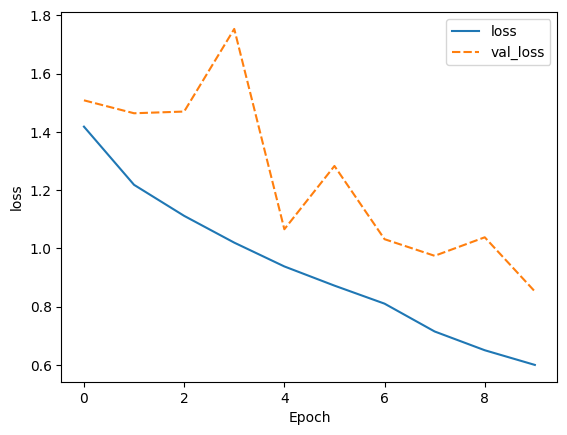

In [9]:
ax = sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
ax.set(xlabel='Epoch', ylabel='loss')

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'accuracy'), (0.0, 1.0)]

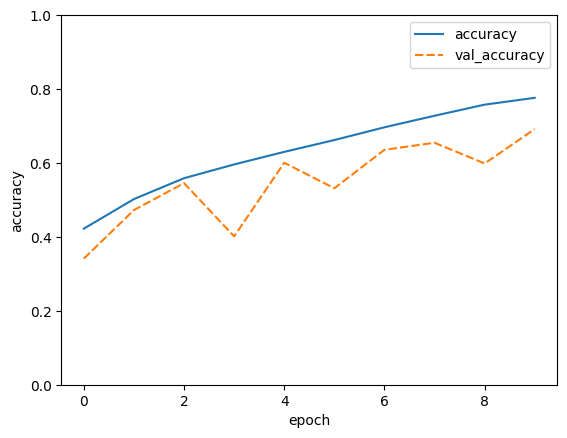

In [10]:
ax = sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']})
ax.set(xlabel='epoch', ylabel='accuracy', ylim=(0,1))